In [318]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [319]:
raw_data = pd.read_csv("calibration.csv", skiprows=range(0,10), delimiter=",")

In [320]:
wells = raw_data["Well"]
samples = raw_data["Sample"]
dilution = raw_data["Dilution"]

In [321]:
blank_data = raw_data.loc[raw_data["Sample"] == "Blank"]

In [322]:
lambdas = blank_data.iloc[:, 3:].columns
values = blank_data.iloc[:, 3:].to_numpy()

# Plotting raw and blank corrected data

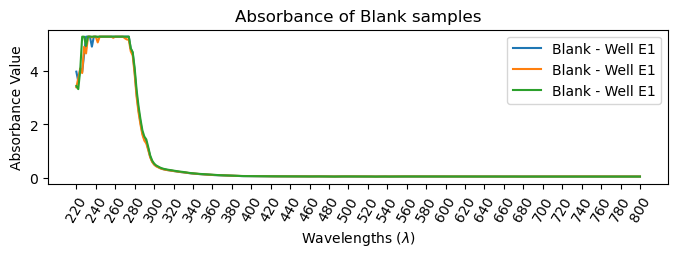

In [323]:
plt.figure(figsize=(8,2))
plt.title("Absorbance of Blank samples")
for n, well in enumerate(values):
    plt.plot(lambdas, well, label="Blank - Well {}".format(blank_data.iloc[0][0]))
plt.xticks(range(0, len(lambdas))[::10], lambdas[::10], rotation=60)
plt.ylabel("Absorbance Value")
plt.xlabel("Wavelengths ($\lambda$)")
plt.legend();

In [331]:
samples_data = raw_data.loc[raw_data["Sample"] == "S1"]

In [332]:
lambdas = samples_data.iloc[:, 3:].columns
values = samples_data.iloc[:, 3:].to_numpy()

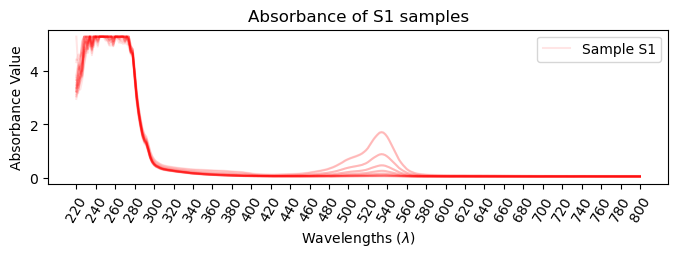

In [333]:
plt.figure(figsize=(8,2))
plt.title("Absorbance of S1 samples")
for n, well in enumerate(values):
    plt.plot(lambdas, well, color="r", label="Sample S1" if n == 0 else "", alpha=0.1)
    #print(max(well))
plt.xticks(range(0, len(lambdas))[::10], lambdas[::10], rotation=60)
plt.ylabel("Absorbance Value")
plt.xlabel("Wavelengths ($\lambda$)")
plt.legend();

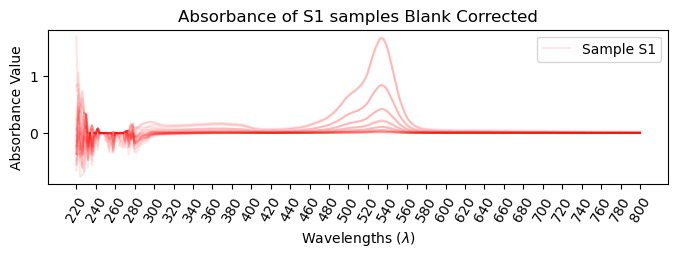

In [336]:
plt.figure(figsize=(8,2))
plt.title("Absorbance of S1 samples Blank Corrected")
for n, well in enumerate(values - blanks):
    plt.plot(lambdas, well, color="r", label="Sample S1" if n == 0 else "", alpha=0.1)
    #print(max(well))
plt.xticks(range(0, len(lambdas))[::10], lambdas[::10], rotation=60)
plt.ylabel("Absorbance Value")
plt.xlabel("Wavelengths ($\lambda$)")
plt.legend();

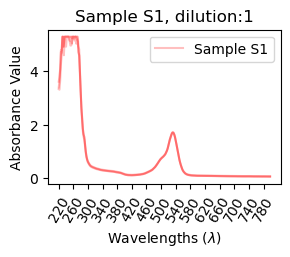

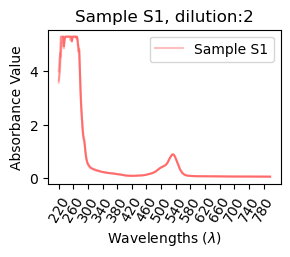

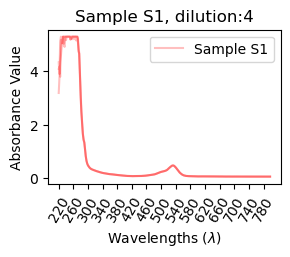

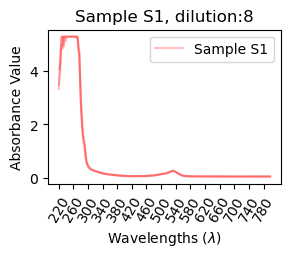

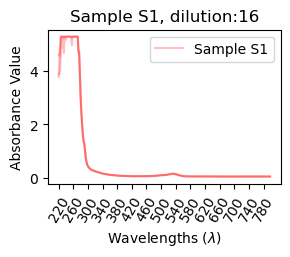

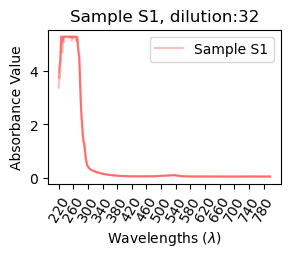

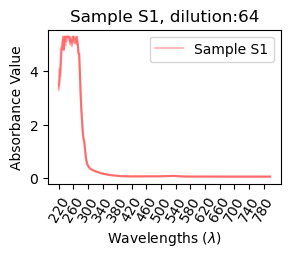

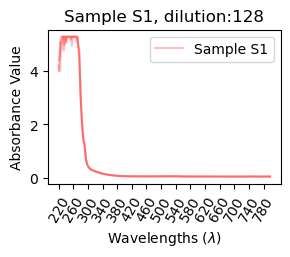

In [220]:
dilutions = np.unique(dilution)
lambdas = samples_data.iloc[:, 3:].columns
for d in dilutions:
    plt.figure(figsize=(3,2))
    plt.title("Sample S1, dilution:{}".format(d))
    data = samples_data.loc[samples_data["Dilution"] == d].to_numpy()[:, 3:]
    for n, values in enumerate(data[:,1:]):
        plt.plot(values, alpha=0.25, color="r", label="Sample S1" if n == 0 else "")
    plt.xticks(range(0, len(lambdas))[::20], lambdas[::20], rotation=60)
    plt.ylabel("Absorbance Value")
    plt.xlabel("Wavelengths ($\lambda$)")
    plt.legend()

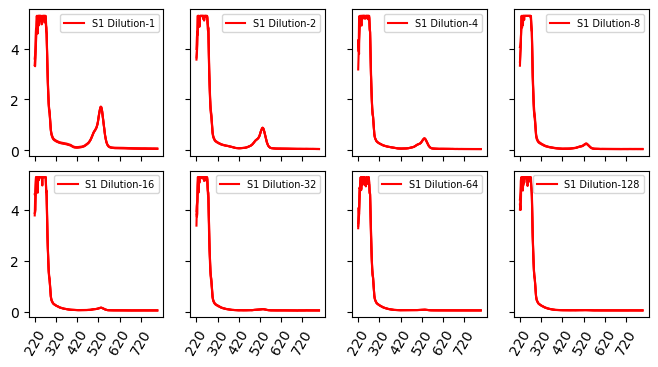

In [288]:
dilutions = np.unique(dilution)
lambdas = samples_data.iloc[:, 3:].columns

fig, axes = plt.subplots(2,4, sharex=True, sharey=True,  figsize=(8, 4))
fig.subplots_adjust(hspace=0.1)
axes=axes.ravel()

for n, d in enumerate(dilutions):
    #plt.figure(figsize=(3,2))
    #axes[n].set_title("Sample S1, dilution:{}".format(d), fontsize=4)
    data = samples_data.loc[samples_data["Dilution"] == d].to_numpy()[:, 3:]
    for e, values in enumerate(data[:,1:]):
        axes[n].plot(values, color="r", label="S1 Dilution-{}".format(d) if e == 0 else "")
    axes[n].legend(loc="upper right", prop={'size': 7})
    axes[n].set_xticks(range(0, len(lambdas))[::50], lambdas[::50], rotation=60)
#plt.ylabel("Absorbance Value")
#fig.set_xlabel("Wavelengths ($\lambda$)")
#fig.supxlabel("Absorbance Value")
#fig.supylabel("Wavelengths ($\lambda$)");

# Finding the E value for every measurement/lambda

In [344]:
def get_E(concentration, absorbance, l_value):
    E = absorbance/(concentration*l_value)
    return E

In [374]:
blank_values = blank_data.iloc[:, 3:].to_numpy()
#First average the blanks
lambdas = samples_data.iloc[:, 3:].columns
blanks = np.mean(blank_values, axis=0)
values = samples_data.iloc[:, 3:].to_numpy()
sample_corrected = values - blanks

In [382]:
original_c = 50
concentrations = 50/dilutions
all_E_values = []
for n, l in enumerate(lambdas):
    E_values = []
    measurements = raw_data.loc[raw_data["Sample"] == "S1"]
    for c, d in zip(concentrations, dilutions):
        samples = measurements.loc[measurements["Dilution"] == d][l] - blanks[n]
        E = get_E(c, samples, 1)
        E_values.append(E)
    all_E_values.append(np.mean(E_values))

## Predicting the concentration again ia E value to validate prediction

In [395]:
def predict_C(absorbance, E_coeff, l_value):
    C = absorbance/(E_coeff*l_value)
    return C

In [399]:
predicted_C = []
for n, l in enumerate(lambdas):
    C_values = []
    measurements = raw_data.loc[raw_data["Sample"] == "S1"]
    for c, d in zip(concentrations, dilutions):
        samples = measurements.loc[measurements["Dilution"] == d][l] - blanks[n]
        C = predict_C(samples, all_E_values[n], 1)
        C_values.append(C)
    predicted_C.append(C_values)

In [404]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [441]:
accuracies_at_lambdas = []
for n,l in enumerate(lambdas):
    pred = predicted_C[n]
    acc_at_Cs = []
    for c_pred,c_og in zip(pred, concentrations):
        accuracy = rmse(np.mean(c_pred), c_og)
        acc_at_Cs.append(accuracy)
    accuracies_at_lambdas.append(np.mean(acc_at_Cs))
        

### Finding the best lambda to predict the concentration

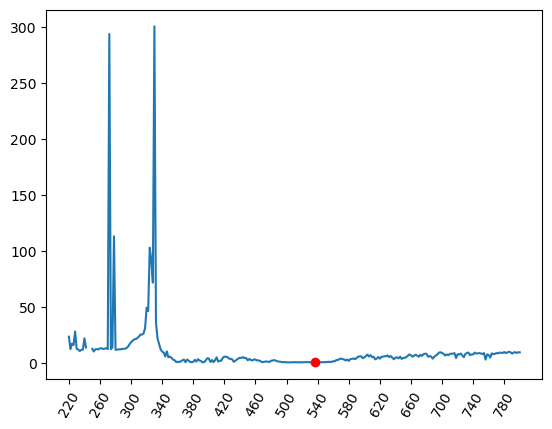

In [418]:
best = np.nanargmin(accuracies_at_lambdas)
plt.plot(lambdas, accuracies_at_lambdas)
plt.plot(lambdas[best], accuracies_at_lambdas[best],"o",  color="r")
plt.xticks(range(0, len(lambdas))[::20], lambdas[::20], rotation=60);

# Predicting the samples

In [432]:
raw_data = pd.read_csv("sample.csv", skiprows=range(0,10), delimiter=",")

In [447]:
blank_data = raw_data.loc[raw_data["Sample"] == "Blank"]["536"]
blank = np.mean(blank_data)

In [450]:
for sample in (raw_data["536"] - blank):
    print("Concentration is ", predict_C(sample, all_E_values[best], 1))

Concentration is  43.83897889052528
Concentration is  42.130584192439855
Concentration is  42.74914089347078
Concentration is  0.009818360333824192
Concentration is  0.03927344133529677
Concentration is  -0.04909180166912137
